In [1]:
%pip install -qU pip sagemaker boto3 jsonlines

Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import jsonlines
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from time import gmtime, strftime, sleep
import tqdm
from sagemaker.s3 import S3Downloader, S3Uploader

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox, Select

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/15/25 16:03:55] INFO     Found credentials from IAM Role:                                   ]8;id=244478;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=24468;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [4]:
sagemaker_session = sagemaker.Session()


[03/15/25 16:03:59] INFO     Found credentials from IAM Role:                                   ]8;id=256787;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=234053;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [38]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "train-test-hack"  # prefix used for all data stored within the bucket
experiment_prefix = "deepar"

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [39]:
region = sagemaker_session.boto_region_name

s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

print(s3_data_path)
print(s3_output_path)

s3://sagemaker-us-west-2-827154710549/train-test-hack/data
s3://sagemaker-us-west-2-827154710549/train-test-hack/output


In [7]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)


[03/15/25 16:04:01] INFO     Same images used for training and inference. Defaulting to image     ]8;id=229258;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=243962;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=750800;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=681453;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [8]:
# maps of quota codes to instance types
ep_instance_quota_code_map = {
    "ml.m5.4xlarge":"L-E2649D46",
    "ml.m5.xlarge":"L-2F737F8D",
}

training_instance_quota_code_map = {
    "ml.c5.4xlarge":"L-E7898792",
    "ml.p2.xlarge":"L-5585E645",
    "ml.m5.4xlarge":"L-AFB011B4",
    "ml.c5.2xlarge":"L-49679826",
    "ml.m5.2xlarge":"L-AD0A282D",
}

In [9]:
# helper to check resource quota in the account
def check_quota(q_map, instance, min_n=1):
    quotas_client = boto3.client("service-quotas")


    r = quotas_client.get_service_quota(
        ServiceCode="sagemaker",
        QuotaCode=q_map[instance],
    )

    q = r["Quota"]["Value"]
    n = r["Quota"]["QuotaName"]
    min_n = min_n

    b = q >= min_n

    print(f"\033[92mSUCCESS: Quota {q} for {n} >= required {min_n}\033[0m" if b else f"\033[91mWARNING: Quota {q} for {n} < required {min_n}\033[0m")

    return b

# helper to get the first available instance in the quota map
def get_best_instance(q_map):
    l = [i for i in
            [i if check_quota(q_map, i) else None 
             for i in q_map.keys()] if i is not None]
    return l[0] if len(l) > 0 else ''

In [10]:
os.makedirs("./data", exist_ok=True)


In [40]:
dataset_zip_file_name = 'LD2011_2014.txt.zip'
dataset_path = './data/LD2011_2014.txt'

s3_dataset_path = f"s3://sustainability-hackathon-dataset/final_data.jsonl"

In [41]:
if not os.path.isfile(dataset_path):
    print(f'Downloading and unzipping the dataset to {dataset_path}')
    s3_client = boto3.client("s3")
    s3_client.download_file(
        f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"./data/{dataset_zip_file_name}"
    )

    zip_ref = zipfile.ZipFile(f"./data/{dataset_zip_file_name}", "r")
    zip_ref.extractall("./data")
    zip_ref.close()
    dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])
else:
    print(f'The dataset {dataset_path} exists, skipping download and unzip!')

The dataset ./data/LD2011_2014.txt exists, skipping download and unzip!


In [54]:
df_raw = pd.read_csv(
    "./data/data.csv",
    sep=',',
    index_col=0,
    decimal='.',
    parse_dates=True,
)

In [55]:
df_raw

,DE_solar_generation_actual,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
utc_timestamp,,,,
2015-01-01 08:00:00,340.85,-1.046,8.8773,51.9464
2015-01-01 09:00:00,1623.00,0.072,34.1583,97.0929
2015-01-01 10:00:00,3017.46,0.866,56.5458,120.2907
2015-01-01 11:00:00,4123.22,1.493,62.8690,126.2112
2015-01-01 12:00:00,3903.66,1.818,54.2607,115.7275
...,...,...,...,...
2019-12-31 19:00:00,0.00,0.767,0.0000,0.0000
2019-12-31 20:00:00,0.00,0.656,0.0000,0.0000
2019-12-31 21:00:00,0.00,0.476,0.0000,0.0000


In [56]:
# resample to 2h intervals
freq = "1h"
div = 8 # 2 hours contain 8x 15 min intervals, you need to  delete the resampled value by 8

data_kw = df_raw.resample(freq).sum() / div
data_kw

,DE_solar_generation_actual,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
utc_timestamp,,,,
2015-01-01 08:00:00,42.60625,-0.130750,1.109662,6.493300
2015-01-01 09:00:00,202.87500,0.009000,4.269787,12.136613
2015-01-01 10:00:00,377.18250,0.108250,7.068225,15.036338
2015-01-01 11:00:00,515.40250,0.186625,7.858625,15.776400
2015-01-01 12:00:00,487.95750,0.227250,6.782587,14.465938
...,...,...,...,...
2019-12-31 19:00:00,0.00000,0.095875,0.000000,0.000000
2019-12-31 20:00:00,0.00000,0.082000,0.000000,0.000000
2019-12-31 21:00:00,0.00000,0.059500,0.000000,0.000000


In [122]:
# select two random time series to include in a small dataset
sample_size = 2
columns_to_keep = np.random.choice(data_kw.columns.to_list(), size=sample_size, replace=False)
columns_to_keep

array(['DE_radiation_diffuse_horizontal',
       'DE_radiation_direct_horizontal'], dtype='<U31')

In [123]:
data_kw_small = data_kw[columns_to_keep]
data_kw_small

,DE_radiation_diffuse_horizontal,DE_radiation_direct_horizontal
utc_timestamp,,
2015-01-01 08:00:00,6.493300,1.109662
2015-01-01 09:00:00,12.136613,4.269787
2015-01-01 10:00:00,15.036338,7.068225
2015-01-01 11:00:00,15.776400,7.858625
2015-01-01 12:00:00,14.465938,6.782587
...,...,...
2019-12-31 19:00:00,0.000000,0.000000
2019-12-31 20:00:00,0.000000,0.000000
2019-12-31 21:00:00,0.000000,0.000000


In [124]:
USE_FULL_DATASET = True


In [125]:
if USE_FULL_DATASET:
    ts_df = data_kw
else:
    ts_df = data_kw_small

In [127]:
# convert the DataFrame to a list of pandas.Series objects
timeseries = []
print(ts_df.shape)
for i in tqdm.trange(ts_df.shape[1]):
    timeseries.append(np.trim_zeros(ts_df.iloc[:, i], trim="f"))
print(ts_df.head())

(43816, 4)


100%|██████████| 4/4 [00:00<00:00, 6340.60it/s]

                     DE_solar_generation_actual  DE_temperature  \
utc_timestamp                                                     
2015-01-01 08:00:00                    42.60625       -0.130750   
2015-01-01 09:00:00                   202.87500        0.009000   
2015-01-01 10:00:00                   377.18250        0.108250   
2015-01-01 11:00:00                   515.40250        0.186625   
2015-01-01 12:00:00                   487.95750        0.227250   

                     DE_radiation_direct_horizontal  \
utc_timestamp                                         
2015-01-01 08:00:00                        1.109662   
2015-01-01 09:00:00                        4.269787   
2015-01-01 10:00:00                        7.068225   
2015-01-01 11:00:00                        7.858625   
2015-01-01 12:00:00                        6.782587   

                     DE_radiation_diffuse_horizontal  
utc_timestamp                                         
2015-01-01 08:00:00               

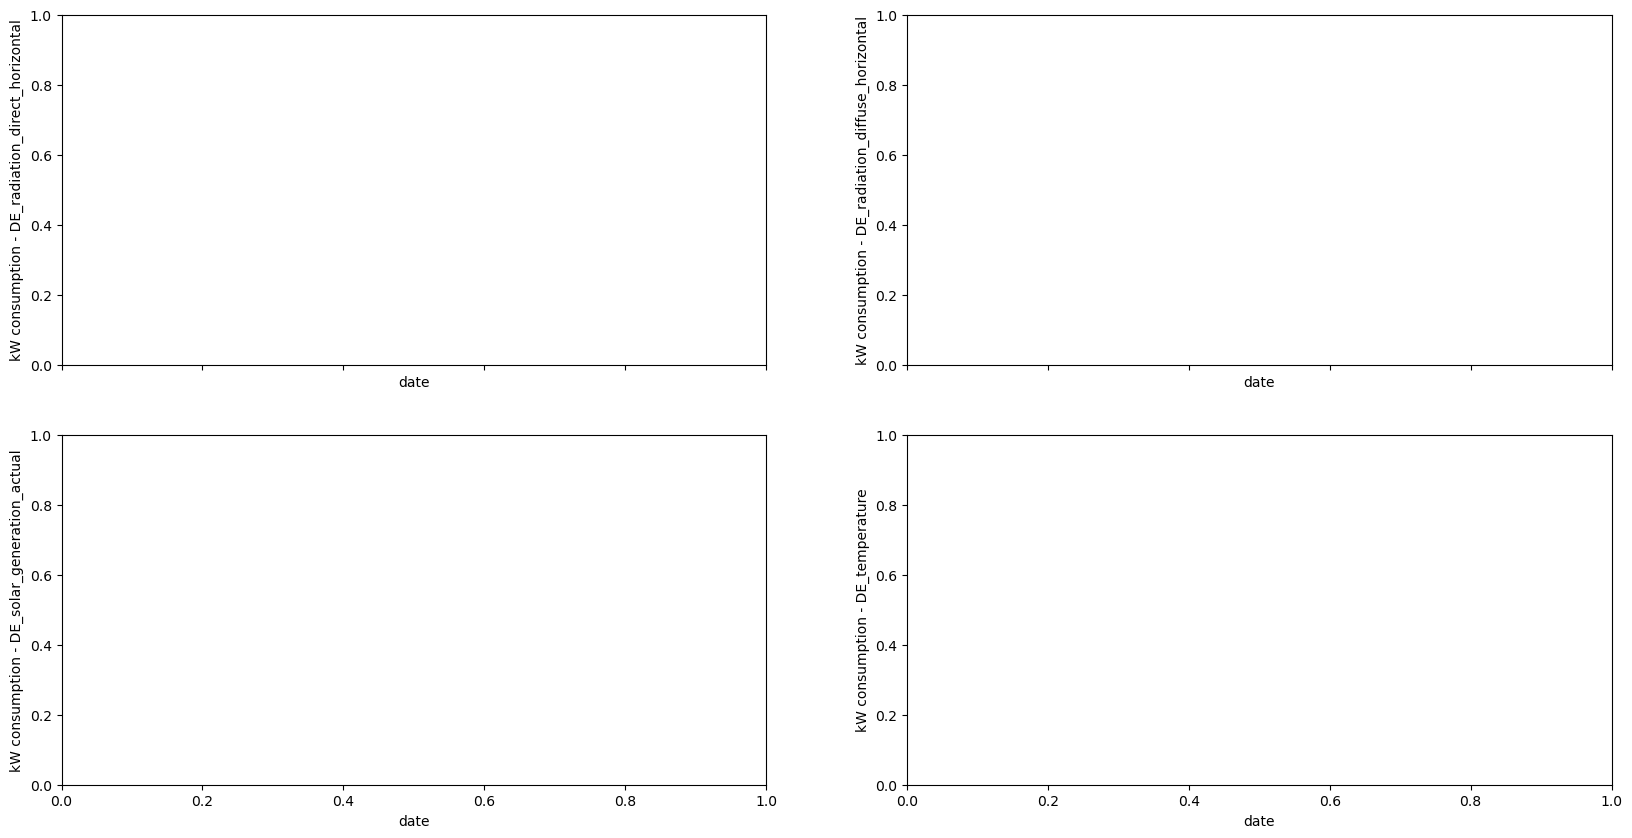

In [128]:
# show random timeseries for 28 day period
sample_size = min(ts_df.shape[1], 10)

n_rows = (sample_size+1)//2
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), sharex=True)
axx = axs.ravel()
for i, ts in enumerate(random.sample(timeseries, sample_size)):
    series = ts.loc["2014-01-01":"2014-01-28"]
    if len(series): series.plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel(f"kW consumption - {ts.name}")
    axx[i].grid(which="minor", axis="x")

In [129]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 12
prediction_length = prediction_days * intervals_per_day

# use same period as the context length, this is the number of state updates accomplished before making predictions
context_length = prediction_days * intervals_per_day

In [130]:
start_dataset = pd.Timestamp("2015-01-01 00:00:00", unit=freq)
end_training = pd.Timestamp("2019-09-01 00:00:00", unit=freq)
print(f"the model sees data from {start_dataset} to {end_training} for training.")

the model sees data from 2015-01-01 00:00:00 to 2019-09-01 00:00:00 for training.


In [131]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),  # use -1, because pandas indexing includes the upper bound
    }
    for ts in timeseries
]
print(f"Training for {len(training_data)} time series")

Training for 4 time series


In [90]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
    }
    for k in range(1, num_test_windows + 1)
    for ts in timeseries
]
print(len(test_data))

16


In [91]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [92]:
%%time
write_dicts_to_file("./data/train.json", training_data)
write_dicts_to_file("./data/test.json", test_data)

CPU times: user 239 ms, sys: 4.01 ms, total: 243 ms
Wall time: 246 ms


In [93]:

print(f"Content of the DeepAR training/test dataset file:")

# Read the jsonl file and show the head an the tail of the first object
with jsonlines.open(f"./data/train.json") as reader:      
    sample = json.dumps(reader.read(), indent=2)
    print(f"{sample[:200]}...\n{sample[len(sample)-200:]}")

Content of the DeepAR training/test dataset file:
{
  "start": "2015-01-01 00:00:00",
  "target": [
    42.60625,
    202.875,
    377.1825,
    515.4025,
    487.9575,
    351.76,
    162.4475,
    15.01875,
    0.0,
    0.0,
    0.0,
    0.0,
    0...
.94625,
    3025.18875,
    3153.92125,
    3072.26625,
    2721.52625,
    2219.7325,
    1579.825,
    865.095,
    256.98875,
    5.40125,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
  ]
}


In [94]:
!aws s3 rm {s3_data_path}/train/ --recursive
!aws s3 rm {s3_data_path}/test/ --recursive

delete: s3://sagemaker-us-west-2-827154710549/train-test-hack/data/train/train.json
delete: s3://sagemaker-us-west-2-827154710549/train-test-hack/data/test/test.json


In [95]:
!aws s3 cp ./data/train.json {s3_data_path}/train/train.json
!aws s3 cp ./data/train.json {s3_data_path}/test/test.json

upload: data/train.json to s3://sagemaker-us-west-2-827154710549/train-test-hack/data/train/train.json
upload: data/train.json to s3://sagemaker-us-west-2-827154710549/train-test-hack/data/test/test.json


In [96]:
### TRAIN A DeepAR Model

In [97]:
# select the instance based on the quota availability
instance_type = "ml.m4.xlarge"

assert instance_type, "You don't have quotas for required processing instance"

In [98]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=sm_role,
    instance_count=1,
    instance_type=instance_type,
    base_job_name="deepar-demo-notebook",
    output_path=s3_output_path,
)

In [107]:
hyperparameters = {
    "time_freq": freq.upper(),
    "epochs": "200", # you can reduce number of epochs for faster training: 100 epochs takes about 14 min to train
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": "24",
    "prediction_length": "6",
}

In [108]:
estimator.set_hyperparameters(**hyperparameters)


In [109]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

[03/15/25 17:19:04] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=764544;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=256702;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=970342;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=671088;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             deepar-demo-notebook-2025-03-15-17-19-04-336                                          

2025-03-15 17:19:05 Starting - Starting the training job...
..25-03-15 17:19:18 Starting - Preparing the instances for training.
...........17:20:06 Downloading - Downloading the training image.
...Docker entrypoint called with argument(s): traineted. Training in progress..
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[03/15/2025 17:22:38 INFO 140512987567936] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'n

In [110]:
print(estimator.output_path)

s3://sagemaker-us-west-2-827154710549/train-test-hack/output


In [111]:
import boto3
model_artifact = estimator.latest_training_job.describe()["ModelArtifacts"]["S3ModelArtifacts"]
s3 = boto3.client("s3")

# Parse the S3 path
s3_bucket = model_artifact.split("/")[2]
s3_key = "/".join(model_artifact.split("/")[3:])

# Download the model locally
s3.download_file(s3_bucket, s3_key, "model.tar.gz")
print("Model downloaded as model.tar.gz")


Model downloaded as model.tar.gz


In [118]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",  # Change instance type based on workload
)

[03/15/25 18:19:01] INFO     Creating model with name: deepar-demo-notebook-2025-03-15-18-19-01-326 ]8;id=792495;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=49405;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=830555;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=713536;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\
                             deepar-demo-notebook-2025-03-15-18-19-01-326                                          

[03/15/25 18:19:02] INFO     Creating endpoint with name                                            ]8;id=624834;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=490785;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\
                             deepar-demo-notebook-2025-03-15-18-19-01-326                                          

------------!

In [ ]:
endpoint_name = predictor.endpoint_name
print("Endpoint Name:", endpoint_name)

In [112]:
### TEST DATA

In [113]:
batch_transformer = estimator.transformer(
    instance_count=1,
    instance_type="ml.m5.large",  # Use a compute instance
    assemble_with="Line",
    output_path="s3://sagemaker-us-west-2-827154710549/train-test-hack/batch_output"  # Change to your output bucket
)

[03/15/25 18:13:17] INFO     Creating model with name: deepar-demo-notebook-2025-03-15-18-13-17-656 ]8;id=918938;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=752787;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

In [117]:
batch_transformer.transform(
    data="s3://sagemaker-us-west-2-827154710549/train-test-hack/data/test/test.json",  # Your test dataset in S3
    content_type="json",
    split_type="Line"
)

batch_transformer.wait()  # Wait for completion

[03/15/25 18:14:38] INFO     Creating transform job with name:                                      ]8;id=379580;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=229974;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#3951\3951]8;;\
                             deepar-demo-notebook-2025-03-15-18-14-38-936                                          

........................

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 batch_transformer.transform(                                                                 │
│   2 │   data="s3://sagemaker-us-west-2-827154710549/train-test-hack/data/test/test.json",  #     │
│   3 │   content_type="json",                                                                     │
│   4 │   split_type="Line"                                                                        │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/workflow/pipel │
│ ine_context.py:346 in wrapper                                                                    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/transformer.py │
│ :318 in transform                                                                                │
│                                                                                                  │
│   315 │   │   )                                                                                  │
│   316 │   │                                                                                      │
│   317 │   │   if wait:                                                                           │
│ ❱ 318 │   │   │   self.latest_transform_job.wait(logs=logs)                                      │
│   319 │                                                                                          │
│   320 │   def transform_with_monitoring(                                                         │
│   321 │   │   self,                                                                              │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/transformer.py │
│ :686 in wait                                                                                     │
│                                                                                                  │
│   683 │                                                                                          │
│   684 │   def wait(self, logs=True):                                                             │
│   685 │   │   if logs:                                                                           │
│ ❱ 686 │   │   │   self.sagemaker_session.logs_for_transform_job(self.job_name, wait=True)        │
│   687 │   │   else:                                                                              │
│   688 │   │   │   self.sagemaker_session.wait_for_transform_job(self.job_name)                   │
│   689                                                      